In [ ]:
# !pip install pandas scipy scikit-learn
!pip install scikit-bio pandas

In [14]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import resample

# Example species abundance data
data = {
    'Site': ['Site1', 'Site2', 'Site3', 'Site4', 'Site5', 'Site6'],
    'Group': ['A', 'A', 'B', 'B', 'C', 'C'],
    'Species1': [5, 3, 2, 4, 6, 8],
    'Species2': [0, 1, 3, 1, 0, 2],
    'Species3': [2, 3, 0, 5, 1, 0]
}

df = pd.DataFrame(data)

# Extract the species data
species_data = df.iloc[:, 2:]

# Calculate Bray-Curtis dissimilarity matrix
bc_distances = pdist(species_data, metric='braycurtis')
bc_dm = squareform(bc_distances)

# Display the dissimilarity matrix
print("Bray-Curtis Dissimilarity Matrix:")
print(bc_dm)

# PERMANOVA implementation
def permanova(distance_matrix, grouping, permutations=999):
    # Calculate the total sum of squares
    total_ss = np.sum(distance_matrix ** 2) / distance_matrix.shape[0]

    # Group centroids
    unique_groups = np.unique(grouping)
    group_means = {group: np.mean(distance_matrix[np.ix_(grouping == group, grouping == group)]) for group in unique_groups}

    # Between-group sum of squares
    ss_between = sum(len(grouping[grouping == group]) * group_means[group] for group in unique_groups)

    # Within-group sum of squares
    ss_within = total_ss - ss_between

    # F-statistic
    df_between = len(unique_groups) - 1
    df_within = len(grouping) - len(unique_groups)
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    F = ms_between / ms_within

    # Permutation test
    permuted_Fs = []
    for _ in range(permutations):
        permuted_groups = np.random.permutation(grouping)
        perm_group_means = {group: np.mean(distance_matrix[np.ix_(permuted_groups == group, permuted_groups == group)]) for group in unique_groups}
        perm_ss_between = sum(len(permuted_groups[permuted_groups == group]) * perm_group_means[group] for group in unique_groups)
        perm_ss_within = total_ss - perm_ss_between
        perm_ms_between = perm_ss_between / df_between
        perm_ms_within = perm_ss_within / df_within
        permuted_Fs.append(perm_ms_between / perm_ms_within)

    p_value = np.sum(permuted_Fs >= F) / permutations
    return F, p_value

# Perform PERMANOVA
grouping = np.array(df['Group'])
F, p_value = permanova(bc_dm, grouping)

# Display PERMANOVA results
print("\nPERMANOVA Results:")
print(f"F-value: {F}")
print(f"p-value: {p_value}")


Bray-Curtis Dissimilarity Matrix:
[[0.         0.28571429 0.66666667 0.29411765 0.14285714 0.41176471]
 [0.28571429 0.         0.5        0.17647059 0.42857143 0.52941176]
 [0.66666667 0.5        0.         0.6        0.66666667 0.46666667]
 [0.29411765 0.17647059 0.6        0.         0.41176471 0.5       ]
 [0.14285714 0.42857143 0.66666667 0.41176471 0.         0.29411765]
 [0.41176471 0.52941176 0.46666667 0.5        0.29411765 0.        ]]

PERMANOVA Results:
F-value: -11.452567975830823
p-value: 0.6896896896896897


In [12]:
import numpy as np
import pandas as pd
from skbio.diversity import beta_diversity
from skbio.stats.distance import mantel, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

# Example data: species abundance across different sites
data = {
    'Site': ['A', 'B', 'C', 'D', 'E'],
    'Species1': [5, 3, 0, 0, 2],
    'Species2': [0, 2, 3, 1, 0],
    'Species3': [1, 0, 1, 4, 5]
}
df = pd.DataFrame(data)
print("Data:\n", df)

# Extract the species data (excluding the site labels)
species_data = df.iloc[:, 1:]

# Compute the Bray-Curtis dissimilarity matrix
bray_curtis_matrix = beta_diversity("braycurtis", species_data, ids=df['Site'])
print("\nBray-Curtis Dissimilarity Matrix:\n", bray_curtis_matrix)

# Create an example environmental distance matrix (e.g., geographic distance)
# Here we assume a hypothetical distance between sites
# We need to convert this into a DistanceMatrix object for compatibility
env_distances_array = pdist(np.random.rand(len(data['Site']), 2))
env_distances_matrix = DistanceMatrix(squareform(env_distances_array), ids=df['Site'])
print("\nEnvironmental Distance Matrix (hypothetical):\n", env_distances_matrix)

# Perform a Mantel test to check the correlation between the Bray-Curtis and environmental distance matrices
mantel_result = mantel(bray_curtis_matrix, env_distances_matrix, method='pearson', permutations=999)
print("\nMantel Test Results:\n", mantel_result)


Data:
   Site  Species1  Species2  Species3
0    A         5         0         1
1    B         3         2         0
2    C         0         3         1
3    D         0         1         4
4    E         2         0         5

Bray-Curtis Dissimilarity Matrix:
 5x5 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E'
Data:
[[0.         0.45454545 0.8        0.81818182 0.53846154]
 [0.45454545 0.         0.55555556 0.8        0.66666667]
 [0.8        0.55555556 0.         0.55555556 0.81818182]
 [0.81818182 0.8        0.55555556 0.         0.33333333]
 [0.53846154 0.66666667 0.81818182 0.33333333 0.        ]]

Environmental Distance Matrix (hypothetical):
 5x5 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E'
Data:
[[0.         0.4253466  0.54385    0.23243958 0.6757725 ]
 [0.4253466  0.         0.66057912 0.33288229 0.53285024]
 [0.54385    0.66057912 0.         0.37406124 0.36843473]
 [0.23243958 0.33288229 0.37406124 0.         0.44337877]
 [0.6757725  0.53285024 0.36843473 0.44337877 0.      

In [13]:
env_distances_array

array([0.4253466 , 0.54385   , 0.23243958, 0.6757725 , 0.66057912,
       0.33288229, 0.53285024, 0.37406124, 0.36843473, 0.44337877])

In [ ]:
# pd.DataFrame(benfords_law_distribution())
# # observed_counts
import pandas as pd
data=pd.read_csv('/content/Species_count.csv')['Count']
# int(str(abs(data[0]))[1])



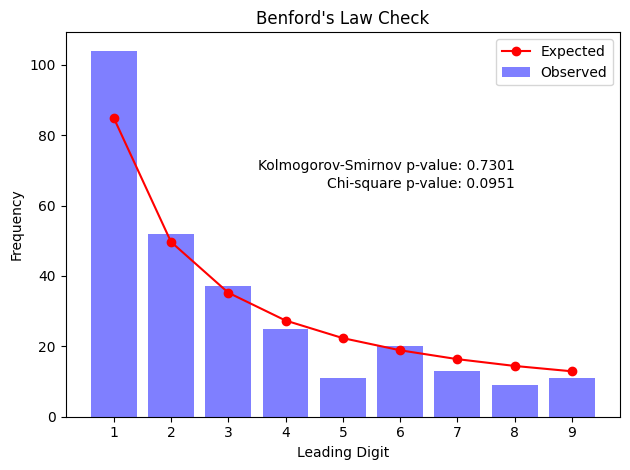

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import kstest

# Function to extract leading digits
def extract_leading_digits(data):
    leading_digits = [int(str(abs(x))[0]) for x in data if abs(x) >= 1]
    return leading_digits

# Function to calculate expected Benford's Law distribution
def benfords_law_distribution():
    return [np.log10(1 + 1 / d) for d in range(1, 10)]

# # Example data generation
# np.random.seed(0)  # for reproducibility
# data = np.random.exponential(scale=100, size=1000)  # Example exponential distribution data

# Extract leading digits
leading_digits = extract_leading_digits(data)

# Count observed frequencies
observed_counts = [leading_digits.count(digit) for digit in range(1, 10)]

# Calculate expected Benford's Law distribution
expected_counts = np.array(benfords_law_distribution()) * len(leading_digits)

# Chi-square test for goodness of fit
chi2_stat, p_val = chisquare(observed_counts, f_exp=expected_counts)
# Kolmogorov-Smirnov test
ks_stat, ks_p_val = kstest(observed_counts, expected_counts)
# Plot observed vs expected distribution
digits = list(range(1, 10))
plt.bar(digits, observed_counts, color='blue', alpha=0.5, label='Observed')
plt.plot(digits, expected_counts, color='red', marker='o', linestyle='-', label='Expected')

plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.title('Benford\'s Law Check')
plt.xticks(digits)
plt.legend()

# Display p-value and test statistics
plt.text(8, 65, f'Chi-square p-value: {p_val:.4f}', fontsize=10, ha='right')
plt.text(8, 70, f'Kolmogorov-Smirnov p-value: {ks_p_val:.4f}', fontsize=10, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

# Function to extract leading digits
def extract_leading_digits(data):
    leading_digits = [int(str(abs(x))[0]) for x in data if abs(x) >= 1]
    return leading_digits

# Function to calculate expected Benford's Law distribution
def benfords_law_distribution():
    return [np.log10(1 + 1 / d) for d in range(1, 10)]

# Function to perform Mantissa test
def mantissa_test(data):
    mantissas = [int(str(abs(x)).split('.')[1][0]) for x in data if abs(x) >= 1]
    observed_counts = [mantissas.count(digit) for digit in range(1, 10)]
    expected_counts = np.array(benfords_law_distribution()) * len(mantissas)
    return observed_counts, expected_counts

# Example data generation
np.random.seed(0)  # for reproducibility
data = np.random.exponential(scale=100, size=1000)  # Example exponential distribution data

# Extract leading digits
leading_digits = extract_leading_digits(data)

# Calculate observed and expected frequencies for Mantissa test
observed_mantissa_counts, expected_mantissa_counts = mantissa_test(data)

# Kolmogorov-Smirnov test
ks_stat, ks_p_val = kstest(leading_digits, 'benford')

# Plot observed vs expected distribution for leading digits
digits = list(range(1, 10))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(digits, observed_mantissa_counts, color='blue', alpha=0.5, label='Observed')
plt.plot(digits, expected_mantissa_counts, color='red', marker='o', linestyle='-', label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.title('Mantissa Test')
plt.xticks(digits)
plt.legend()
plt.text(8, 0.2, f'KS p-value: {ks_p_val:.4f}', fontsize=10, ha='right')

# Plot ECDF for Kolmogorov-Smirnov test
plt.subplot(1, 2, 2)
plt.hist(leading_digits, bins=9, density=True, cumulative=True, color='blue', alpha=0.5, label='ECDF')
plt.plot(digits, benfords_law_distribution(), color='red', marker='o', linestyle='-', label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Cumulative Probability')
plt.title('Kolmogorov-Smirnov Test')
plt.xticks(digits)
plt.legend()

plt.tight_layout()
plt.show()


AttributeError: module 'scipy.stats.distributions' has no attribute 'benford'

Bradford's law is a principle stating that a small number of items contribute to the majority of the occurrences in a given dataset, often observed in information retrieval and library science.

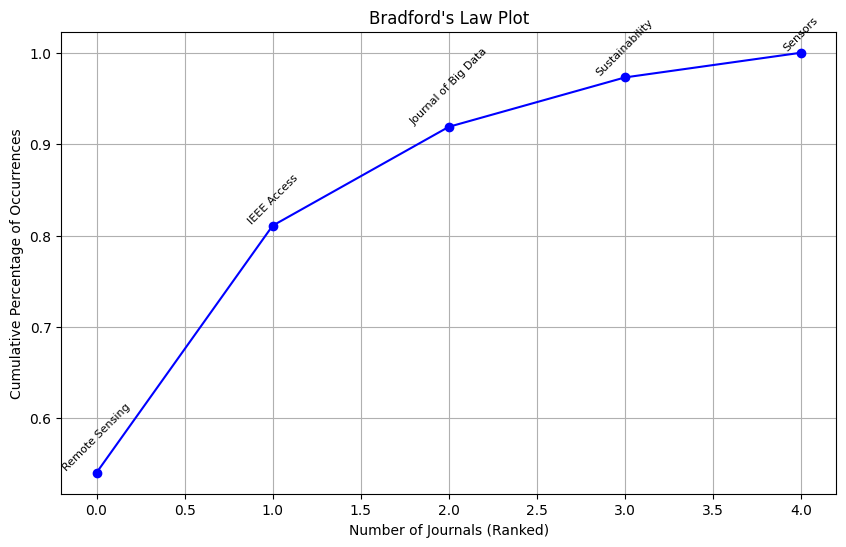

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_bradfords_law(data):
    # Sort the data in descending order
    data_sorted = sorted(data, reverse=True)

    # Calculate cumulative percentages
    cumulative_percentages = np.cumsum(data_sorted) / np.sum(data_sorted)

    return data_sorted, cumulative_percentages

# Sample data (number of occurrences of each journal)
journals = ["Remote Sensing", "IEEE Access", "Journal of Big Data", "Sustainability", "Sensors"]
occurrences = [1000, 500, 200, 100, 50]  # Sample occurrences for the top five journals

# Calculate Bradford's Law
sorted_data, cumulative_percentages = calculate_bradfords_law(occurrences)

# Plot Bradford's Law
plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentages, color='blue', marker='o', linestyle='-')
plt.title("Bradford's Law Plot")
plt.xlabel("Number of Journals (Ranked)")
plt.ylabel("Cumulative Percentage of Occurrences")
plt.grid(True)

# Annotate the top five journals
for i in range(len(journals)):
    plt.text(i, cumulative_percentages[i], journals[i], ha='center', va='bottom', fontsize=8, rotation=45)

plt.show()


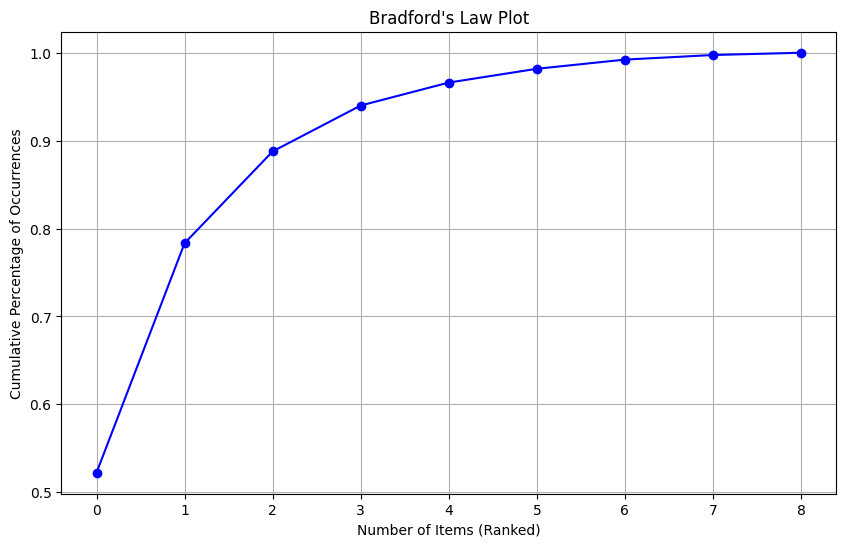

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bradfords_law(data):
    # Sort the data in descending order
    data_sorted = sorted(data, reverse=True)

    # Calculate cumulative percentages
    cumulative_percentages = np.cumsum(data_sorted) / np.sum(data_sorted)

    # Plot Bradford's law
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_percentages, color='blue', marker='o', linestyle='-')
    plt.title("Bradford's Law Plot")
    plt.xlabel("Number of Items (Ranked)")
    plt.ylabel("Cumulative Percentage of Occurrences")
    plt.grid(True)
    plt.show()

# Sample data (number of occurrences of each item)
data = [1000, 500, 200, 100, 50, 30, 20, 10, 5]

# Plot Bradford's law
plot_bradfords_law(data)


In [ ]:
pip install squarify

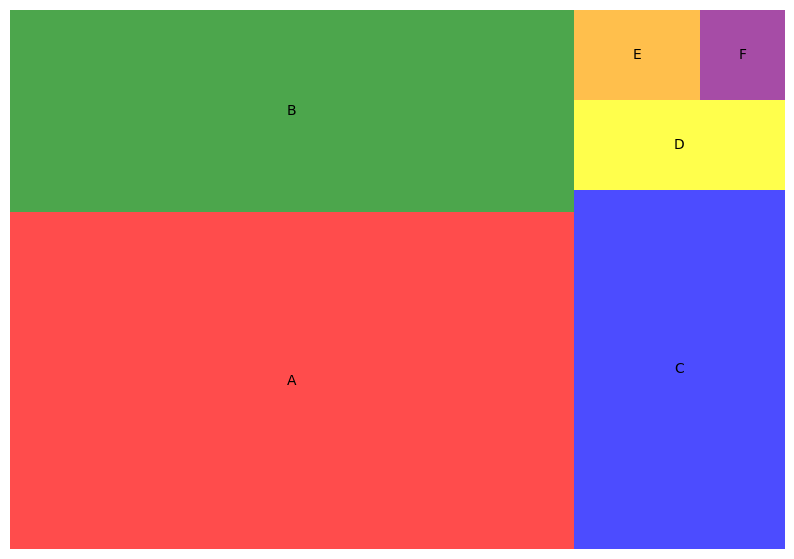

In [ ]:
import matplotlib.pyplot as plt
import squarify

# Data for the foam tree
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting the foam tree
plt.figure(figsize=(10, 7))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7)
plt.axis('off')  # Remove axes
plt.show()


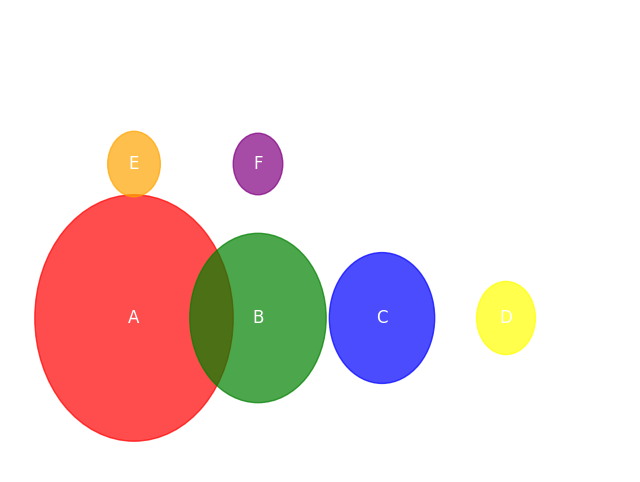

In [ ]:
import matplotlib.pyplot as plt

def plot_shapes_with_size(sizes, labels, colors):
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    max_size = max(sizes)
    min_size = min(sizes)
    range_size = max_size - min_size

    for i, size in enumerate(sizes):
        # Scale the radius based on the size of the data
        radius = 0.2 + 0.6 * ((size - min_size) / range_size)
        # Plot circles with varying sizes
        circle = plt.Circle((i % 4, i // 4), radius, color=colors[i], alpha=0.7)
        ax.add_artist(circle)
        # Add label
        plt.text(i % 4, i // 4, labels[i], ha='center', va='center', color='white', fontsize=12)

    plt.xlim(-1, 4)  # Adjust x-axis limit based on the number of items
    plt.ylim(-1, 2)  # Adjust y-axis limit based on the number of items
    plt.axis('off')
    plt.show()

# Sample data
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting shapes with size on a rectangular canvas
plot_shapes_with_size(sizes, labels, colors)


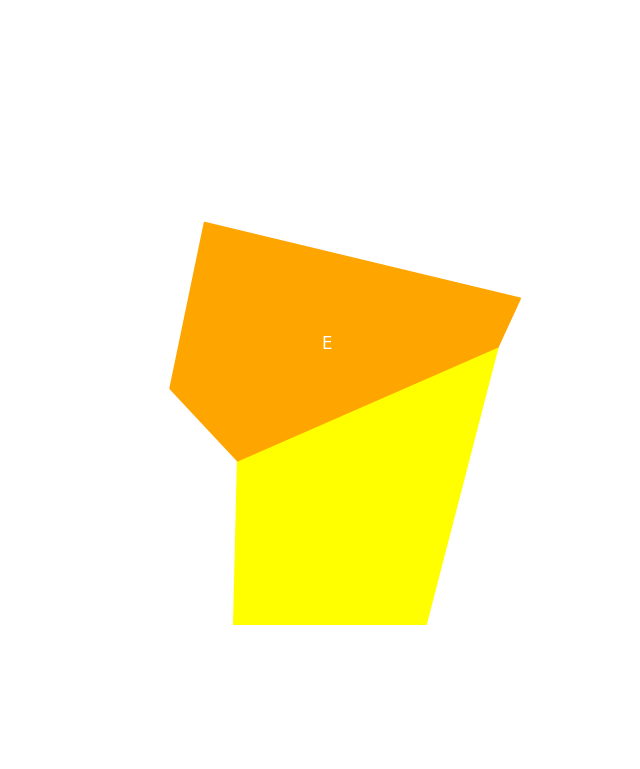

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

def plot_smart_shapes(sizes, labels, colors):
    num_items = len(sizes)
    points = np.random.rand(num_items, 2)  # Random points for Voronoi tessellation
    vor = Voronoi(points)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    for region_idx in range(len(vor.regions)):
        if not -1 in vor.regions[region_idx] and len(vor.regions[region_idx]) > 0:
            polygon = [vor.vertices[i] for i in vor.regions[region_idx]]
            ax.fill(*zip(*polygon), color=colors[region_idx % num_items])
            ax.text(np.mean([v[0] for v in polygon]), np.mean([v[1] for v in polygon]), labels[region_idx % num_items],
                    horizontalalignment='center', verticalalignment='center', fontsize=12, color='white')

    plt.show()

# Sample data
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting the FoamTree-like visualization with smart shapes using Voronoi tessellation
plot_smart_shapes(sizes, labels, colors)


<ipython-input-11-6648b0e382a6>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  hexagon = plt.Polygon(np.column_stack([[x, x + 0.5, x + 1, x + 1, x + 0.5, x],


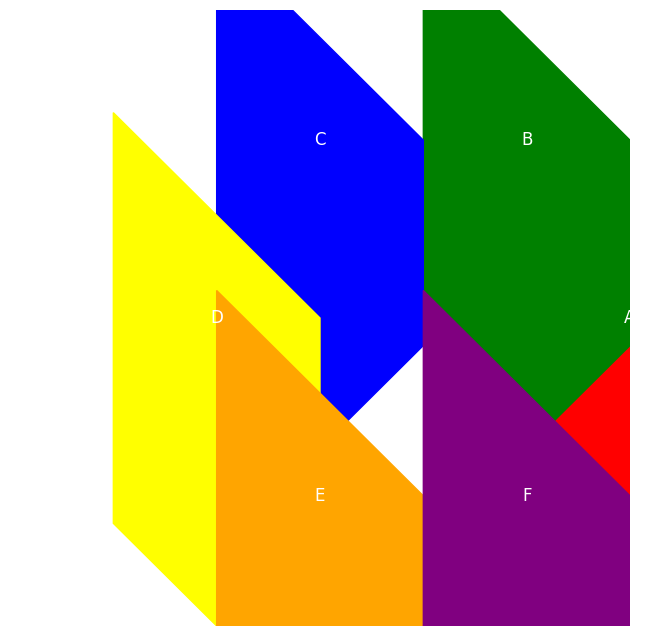

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hexagons(sizes, labels, colors):
    num_items = len(sizes)
    radius = 1
    angle = np.linspace(0, 2 * np.pi, num_items + 1)

    plt.figure(figsize=(8, 8))

    for i in range(num_items):
        x = radius * np.cos(angle[i])
        y = radius * np.sin(angle[i])
        hexagon = plt.Polygon(np.column_stack([[x, x + 0.5, x + 1, x + 1, x + 0.5, x],
                                               [y + 1, y + 0.5, y, y - 1, y - 1.5, y - 1]]),
                              closed=True, color=colors[i], edgecolor='black')
        plt.gca().add_patch(hexagon)
        plt.text(x + 0.5, y, labels[i], ha='center', va='center', fontsize=12, color='white')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axis('off')
    plt.show()

# Sample data
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting the FoamTree-like visualization with hexagons
plot_hexagons(sizes, labels, colors)


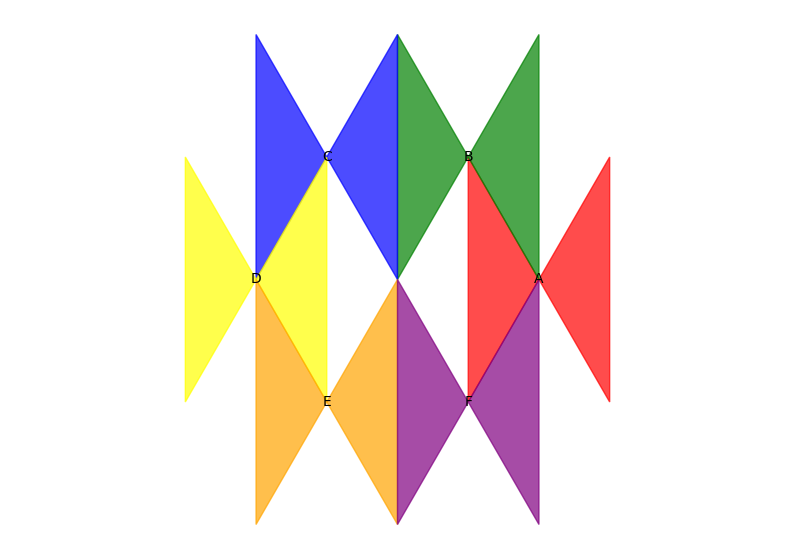

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting hexagonal shapes
plt.figure(figsize=(10, 7))

num_items = len(sizes)
radius = 1
angle = np.linspace(0, 2 * np.pi, num_items + 1)

for i in range(num_items):
    x_hex = radius * np.cos(angle[i])
    y_hex = radius * np.sin(angle[i])
    hexagon = plt.Polygon([[x_hex, y_hex], [x_hex + 0.5, y_hex + np.sqrt(3)/2],
                           [x_hex + 0.5, y_hex - np.sqrt(3)/2], [x_hex, y_hex],
                           [x_hex - 0.5, y_hex - np.sqrt(3)/2], [x_hex - 0.5, y_hex + np.sqrt(3)/2],
                           [x_hex, y_hex]], color=colors[i], alpha=0.7)
    plt.gca().add_patch(hexagon)
    plt.text(x_hex, y_hex, labels[i], ha='center', va='center')

plt.axis('equal')
plt.axis('off')
plt.show()


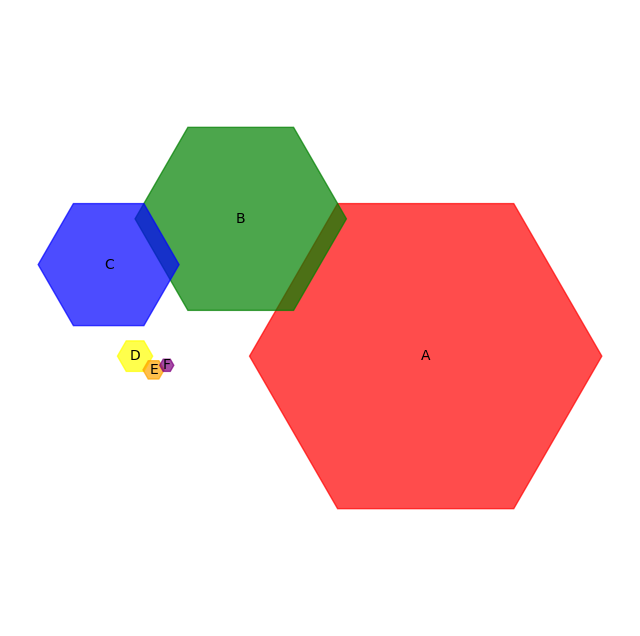

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

def plot_hexagon(x, y, size, color, label):
    """Function to plot a hexagon."""
    angle = np.linspace(0, 2*np.pi, 7)
    x_hex = x + size * np.cos(angle)
    y_hex = y + size * np.sin(angle)
    plt.fill(x_hex, y_hex, color=color, alpha=0.7)
    plt.text(x, y, label, ha='center', va='center')

# Plotting the FoamTree-like visualization with hexagons
plt.figure(figsize=(8, 8))
for i, (size, color, label) in enumerate(zip(sizes, colors, labels)):
    x = 1.5 * size * np.cos(i * np.pi / 3)
    y = 1.5 * size * np.sin(i * np.pi / 3)
    plot_hexagon(x, y, size, color, label)
plt.axis('equal')
plt.axis('off')
plt.show()



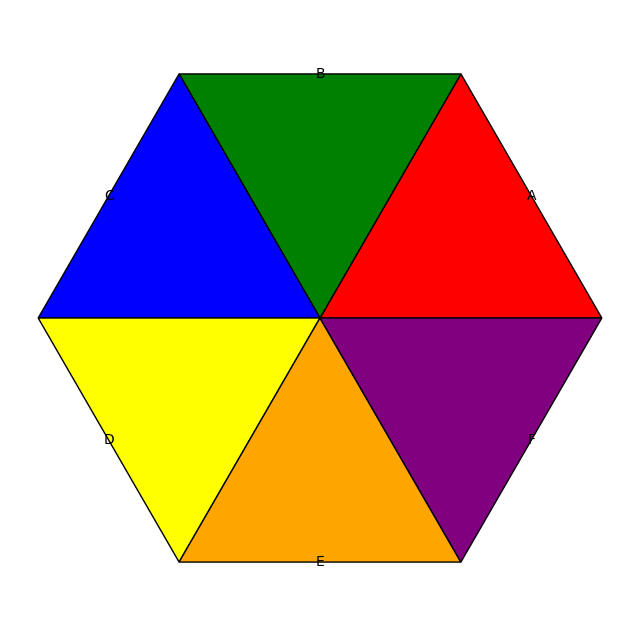

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vergoni(sizes, labels, colors):
    num_items = len(sizes)
    # Hexagon parameters
    radius = 1
    angle = np.linspace(0, 2*np.pi, num_items+1)

    # Coordinates of the vertices of a regular hexagon
    x_hex = radius * np.cos(angle)
    y_hex = radius * np.sin(angle)

    # Plotting the Vergoni shape
    plt.figure(figsize=(8, 8))
    for i in range(num_items):
        # Vertices of the hexagon
        vertices = np.vstack(([0, 0], [x_hex[i], y_hex[i]], [x_hex[i+1], y_hex[i+1]]))
        plt.fill(vertices[:, 0], vertices[:, 1], color=colors[i], edgecolor='black')
        # Labeling
        plt.text((x_hex[i] + x_hex[i+1]) / 2, (y_hex[i] + y_hex[i+1]) / 2, labels[i], ha='center', va='center')

    plt.axis('equal')
    plt.axis('off')  # Remove axes
    plt.show()

# Data for the Vergoni shape
sizes = [500, 300, 200, 50, 30, 20]
labels = ["A", "B", "C", "D", "E", "F"]
colors = ["red", "green", "blue", "yellow", "orange", "purple"]

# Plotting the Vergoni shape
plot_vergoni(sizes, labels, colors)


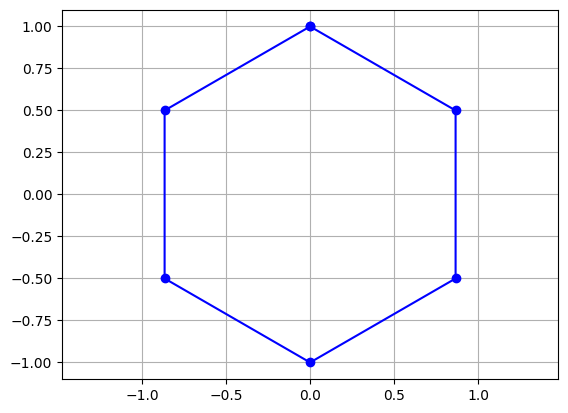

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hexagon():
    # Coordinates of the vertices of a regular hexagon
    vertices = np.array([[0, 1], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2, -0.5],
                         [0, -1], [-np.sqrt(3)/2, -0.5], [-np.sqrt(3)/2, 0.5], [0, 1]])

    # Plotting the hexagon
    plt.figure()
    plt.plot(vertices[:, 0], vertices[:, 1], marker='o', color='b')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_hexagon()
